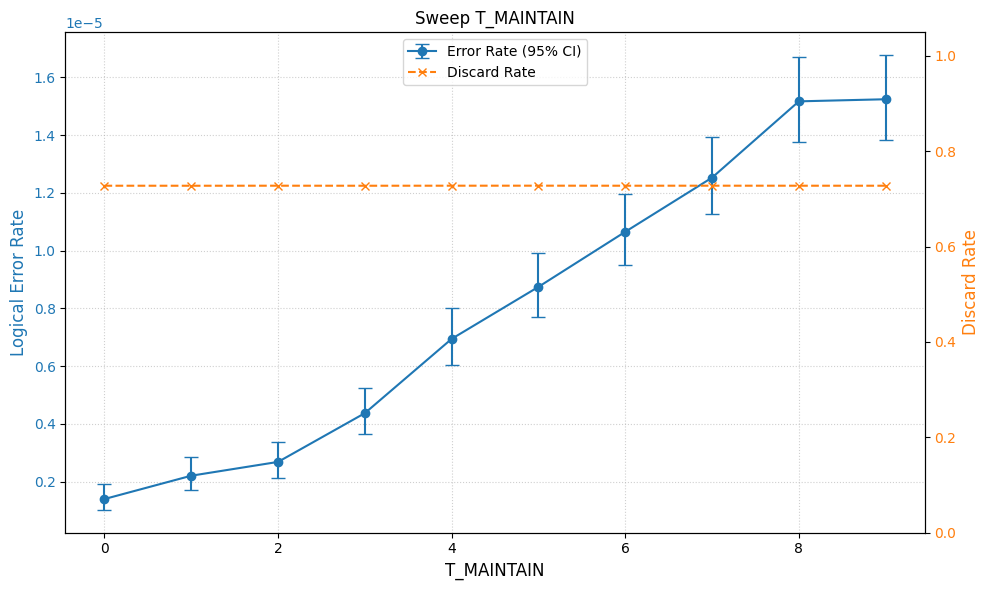

In [19]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_maintain.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_MAINTAIN')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_MAINTAIN', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_MAINTAIN')
plt.tight_layout()
plt.show()


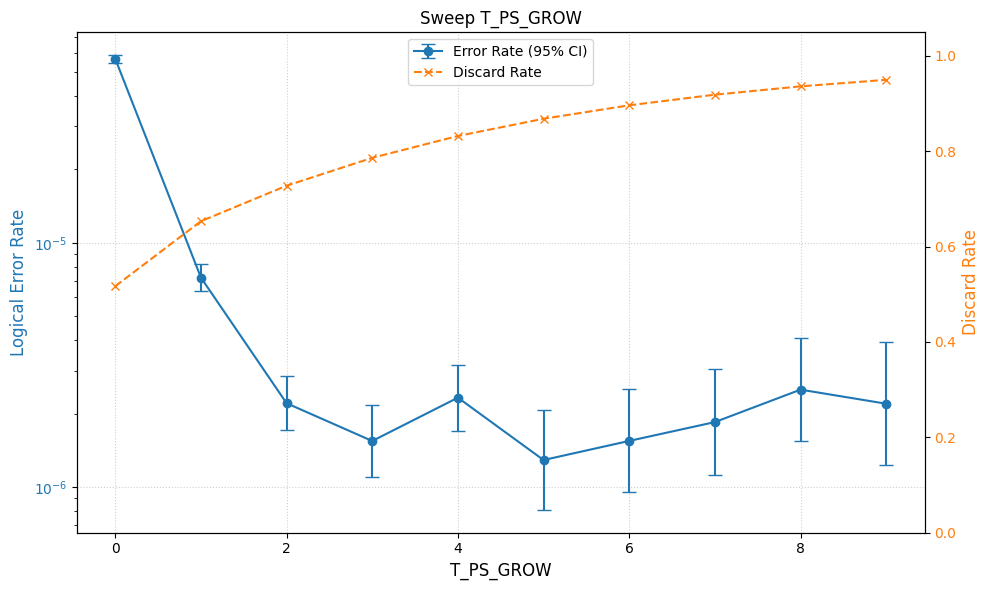

In [18]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_ps.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_PS_GROW')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_PS_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_PS_GROW')
plt.tight_layout()
plt.show()


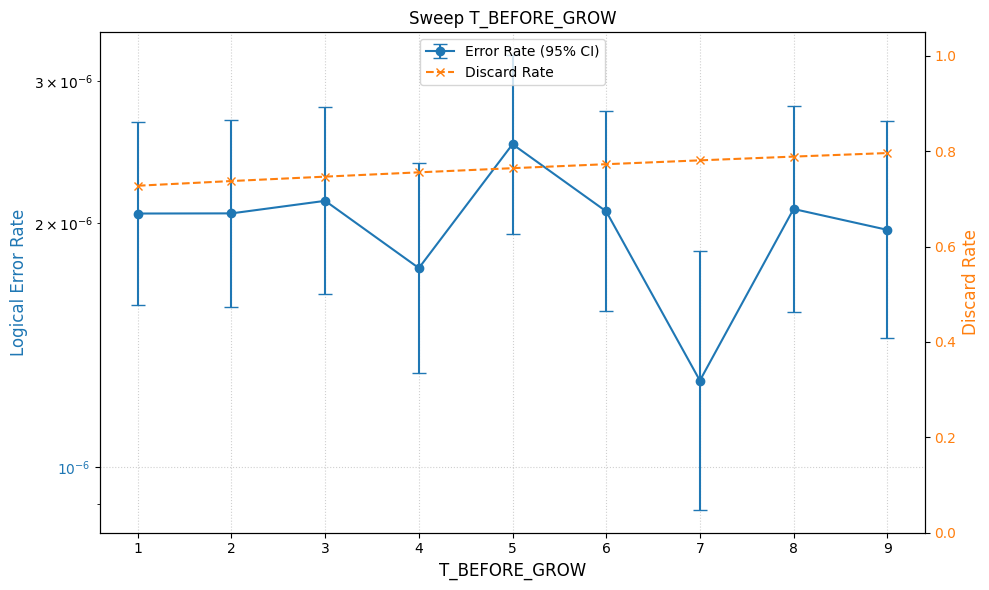

In [21]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_bfg.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_BEFORE_GROW')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_BEFORE_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_BEFORE_GROW')
plt.tight_layout()
plt.show()


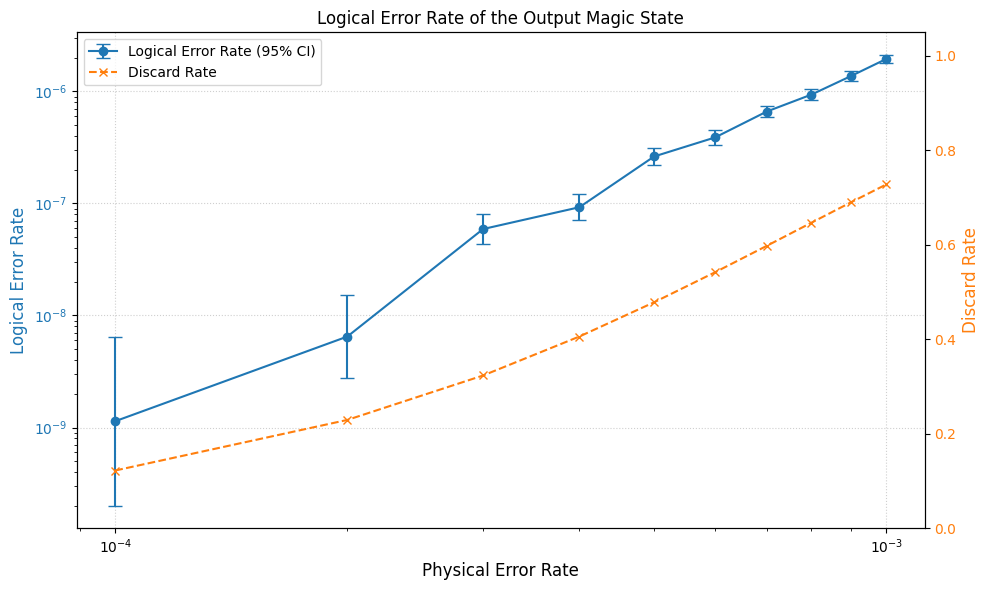

In [4]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_err.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('p')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('Physical Error Rate', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')
ax1.set_xscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Logical Error Rate (95% CI)', 'Discard Rate'], loc='upper left')

plt.title('Logical Error Rate of the Output Magic State')
plt.tight_layout()
plt.show()


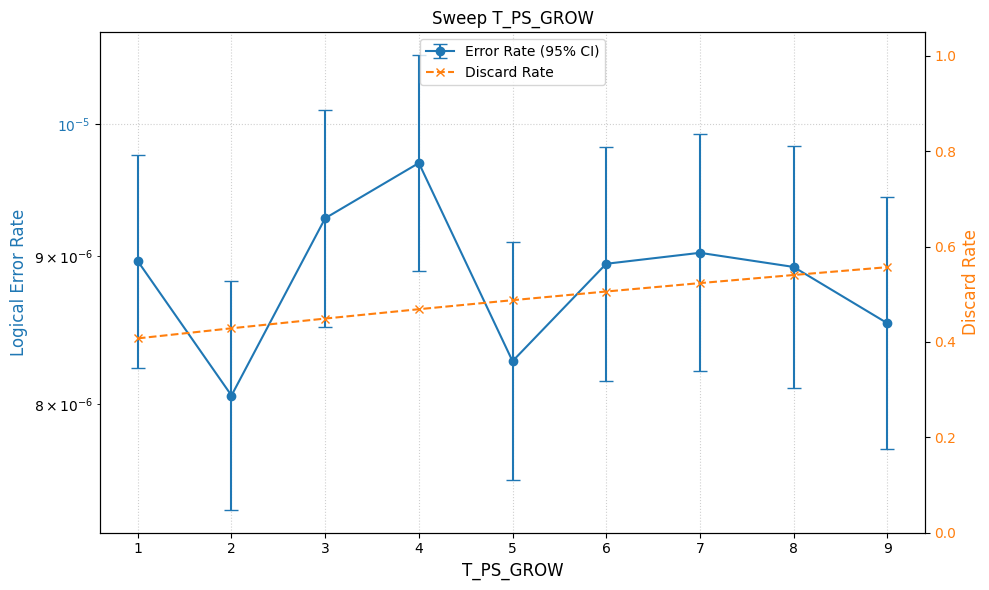

In [8]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../no_grow/sinter_results_sweep_ps.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_BEFORE_GROW')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_PS_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_PS_GROW')
plt.tight_layout()
plt.show()

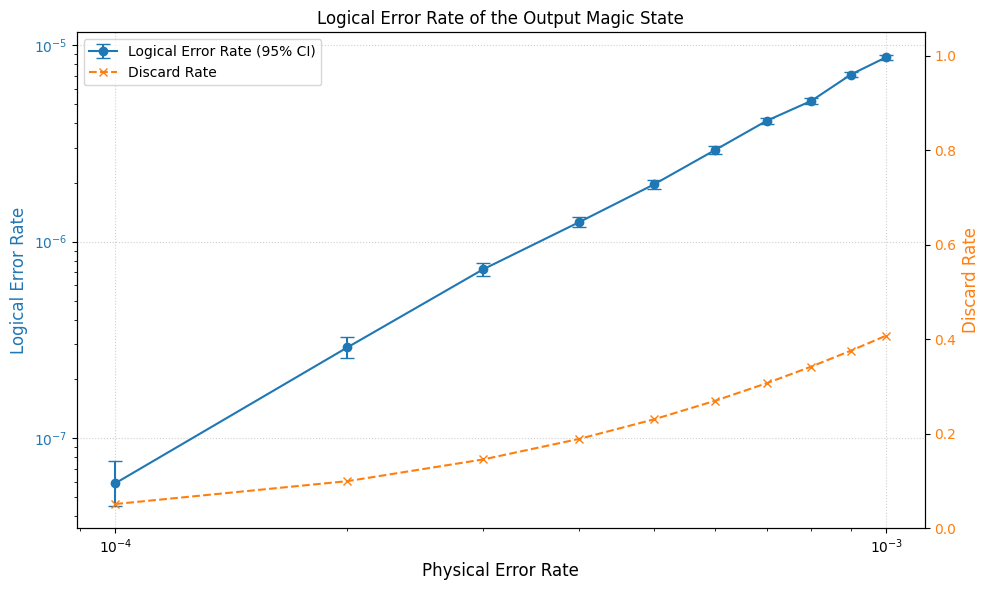

In [6]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../no_grow/sinter_results_sweep_err.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('p')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('Physical Error Rate', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')
ax1.set_xscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Logical Error Rate (95% CI)', 'Discard Rate'], loc='upper left')

plt.title('Logical Error Rate of the Output Magic State')
plt.tight_layout()
plt.show()